# 라이브러리 가져오기

In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
import json
import random
import folium
import matplotlib.pylab as plt
%matplotlib inline

# MCLP를 위한 선형계획법 툴
from pulp import *

# 시각화 툴 : Pydeck
import pydeck as pdk

# 지리 데이터 전처리 툴 : Shapely
import shapely.speedups
shapely.speedups.enable()
from shapely.ops import unary_union
from shapely.geometry import Point, MultiLineString, mapping, shape

mapbox_key = 'pk.eyJ1IjoicWlxaTY1NCIsImEiOiJja2xnYW0xdWgyMmUyMnVxZWl2NGJpYng3In0.VIYWYBixklc-pAM9w7AjMA'

import warnings
warnings.filterwarnings(action='ignore')

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

/opt/app-root/lib/python3.6/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


# 데이터 불러오기 & 전처리

In [2]:
#위험지수 
df_all = pd.read_csv('df_all_final.csv')

## 거주인구가 0인 격자 제외

In [3]:
#거주인구 0인 지역 제외 >> pop
pop = gpd.read_file('data/10.김해시_성연령별_거주인구격자.geojson')

pop_sum = pop.iloc[:,1:].sum(axis=1)
pop_sum = pd.DataFrame({"gid": pop['gid'], "pop_sum": pop_sum})
pop_zero = pop_sum[pop_sum['pop_sum']==0]
pop_zero
pop = pop_sum[pop_sum['pop_sum']>0]
#df_a와 거지인구 0인 지역 제외
df_all = pd.merge(pop, df_all, on='gid', how='left')
df_all['gid']

0        마라099990
1        마라099990
2        마라099990
3        마라099990
4        마라099991
           ...   
10027    마마346005
10028    마마346006
10029    마마346006
10030    마마346006
10031    마마346006
Name: gid, Length: 10032, dtype: object

## 하천 격자 제외

In [4]:
df_5 = gpd.read_file('data/5.김해시_격자(100X100).geojson')
df_5 = gpd.GeoDataFrame(df_5)
df_9 = gpd.read_file('data/9.김해시_하천현황.geojson')
df_9 = gpd.GeoDataFrame(df_9)

#하천 데이터 결합
df_river=gpd.sjoin(df_9,df_5,how='left',op='intersects')
df_river['river'] = 1
df_river

df_all = pd.merge(df_all, df_river, on='gid', how='outer')

#전체 격자 중 하천 데이터 빼기
df_all = df_all[df_all['river']!=1]
df_all

,gid,pop_sum,Unnamed: 0,cctv_n_points,police_weight,security_light_n_points,bell_n_points,cctv_buffer,year,geometry_x,어린이집,유치원,초중고,초등학교,중학교,고등학교,아동안전지킴이집,RIVLEN2,RIV_NAM_1,geometry_y,index_right,river
0,마라099990,97.0,22608.0,0.0,0.0,3.0,0.0,1.0,2018.0,MULTIPOLYGON (((128.7084695727423 35.280458361...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,None,NaN,NaN
1,마라099990,97.0,22609.0,0.0,17.0,3.0,0.0,1.0,2019.0,MULTIPOLYGON (((128.7084695727423 35.280458361...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,None,NaN,NaN
2,마라099990,97.0,22610.0,0.0,17.0,3.0,0.0,1.0,2020.0,MULTIPOLYGON (((128.7084695727423 35.280458361...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,None,NaN,NaN
3,마라099990,97.0,22611.0,0.0,0.0,3.0,1.0,1.0,2021.0,MULTIPOLYGON (((128.7084695727423 35.280458361...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,None,NaN,NaN
4,마라099991,30.0,0.0,2.0,0.0,4.0,0.0,1.0,2018.0,MULTIPOLYGON (((128.7084829680048 35.281359862...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,None,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10031,마마346005,25.0,22559.0,3.0,33.0,3.0,0.0,1.0,2021.0,MULTIPOLYGON (((128.9802456172423 35.290961708...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,None,NaN,NaN
10032,마마346006,34.0,32716.0,0.0,0.0,0.0,0.0,0.0,2018.0,MULTIPOLYGON (((128.9802620307694 35.291863107...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,None,NaN,NaN
10033,마마346006,34.0,32717.0,0.0,0.0,0.0,0.0,1.0,2019.0,MULTIPOLYGON (((128.9802620307694 35.291863107...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,None,NaN,NaN
10034,마마346006,34.0,32718.0,0.0,0.0,0.0,0.0,1.0,2020.0,MULTIPOLYGON (((128.9802620307694 35.291863107...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,None,NaN,NaN


In [5]:
df_all.columns

Index(['gid', 'pop_sum', 'Unnamed: 0', 'cctv_n_points', 'police_weight',
       'security_light_n_points', 'bell_n_points', 'cctv_buffer', 'year',
       'geometry_x', '어린이집', '유치원', '초중고', '초등학교', '중학교', '고등학교', '아동안전지킴이집',
       'RIVLEN2', 'RIV_NAM_1', 'geometry_y', 'index_right', 'river'],
      dtype='object')

In [6]:
df_all = df_all[[ 'gid', 'cctv_n_points', 'police_weight',
       'security_light_n_points', 'bell_n_points', 'cctv_buffer', 'year',
      '어린이집', '유치원', '초중고', '초등학교', '중학교', '고등학교', '아동안전지킴이집']]

## 변수 간 상관계수

<AxesSubplot:>

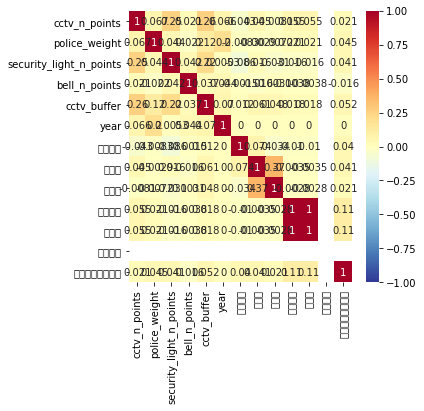

In [7]:
cor = df_all.corr(method='pearson')
#heatmap으로 상관관계를 표시
import seaborn as sns
plt.rcParams["figure.figsize"] = (5,5)
sns.heatmap(cor,
           annot = True, #실제 값 화면에 나타내기
           cmap = 'RdYlBu_r', #색상
           vmin = -1, vmax=1 , #컬러차트 영역 -1 ~ +1
          )

In [8]:
df_all.isna().sum()

gid                        0
cctv_n_points              0
police_weight              0
security_light_n_points    0
bell_n_points              0
cctv_buffer                0
year                       0
어린이집                       0
유치원                        0
초중고                        0
초등학교                       0
중학교                        0
고등학교                       0
아동안전지킴이집                   0
dtype: int64

In [9]:
df_all2= df_all.copy()

## 종속변수 확인(로그스케일변환, 이상치제거)

<AxesSubplot:xlabel='police_weight'>

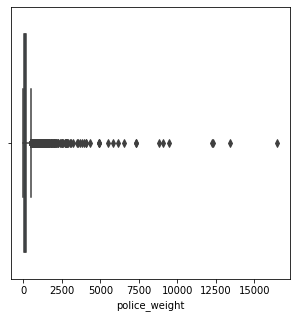

In [10]:
sns.boxplot(df_all['police_weight'])

In [11]:
df_all['police_weight'] = np.log1p(df_all['police_weight'])
quantile_25 = np.quantile(df_all['police_weight'], 0.25)
quantile_75 = np.quantile(df_all['police_weight'],0.75)

IQR = quantile_75 - quantile_25

minimum = quantile_25 - 1.5 * IQR
maximum = quantile_75 + 1.5 * IQR

df_all = df_all[(minimum <= df_all['police_weight']) & (df_all['police_weight'] <= maximum)]

<AxesSubplot:xlabel='police_weight'>

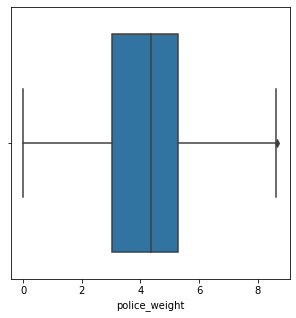

In [12]:
sns.boxplot(df_all['police_weight'])

# 다중선형회귀(Multiple Linear Regression)

In [13]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [14]:
df_reg = df_all.copy()
col=['cctv_n_points', 'security_light_n_points', 'bell_n_points', 'cctv_buffer',
      '어린이집', '유치원', '초중고', '초등학교', '중학교', '고등학교', '아동안전지킴이집']
X = df_reg[col]
y = df_reg['police_weight']

model  = sm.OLS(y,X)
res =model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          police_weight   R-squared (uncentered):                   0.762
Model:                            OLS   Adj. R-squared (uncentered):              0.762
Method:                 Least Squares   F-statistic:                              3342.
Date:                Fri, 19 Aug 2022   Prob (F-statistic):                        0.00
Time:                        02:05:44   Log-Likelihood:                         -20476.
No. Observations:                9413   AIC:                                  4.097e+04
Df Residuals:                    9404   BIC:                                  4.103e+04
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
cctv_n_points               0.1261      0.018      7.037      0.000       0.091       0.161
security_light_n_points     0.0913      0.007     13.430      0.000       0.078       0.105
bell_n_points               0.0315      0.083      0.381      0.703      -0.130       0.193
cctv_buffer                 3.8893      0.033    116.193      0.000       3.824       3.955
어린이집                        0.9212      0.042     21.955      0.000       0.839       1.003
유치원                        -0.2648      0.200     -1.326      0.185      -0.656       0.127
초중고                         0.6397      0.231      2.764      0.006       0.186       1.093
초등학교                        0.6325      0.380      1.664      0.096      -0.113       1.378
중학교                         0.6325      0.380      1.664      0.096      -0.113       1.378
고등학교                             0          0        nan        nan           0           0
아동안전지킴이집                    0.8077      0.174      4.652      0.000       0.467       1.148
==============================================================================
Omnibus:                       97.581   Durbin-Watson:                   0.626
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              134.342
Skew:                           0.138   Prob(JB):                     6.73e-30
Kurtosis:                       3.516   Cond. No.                          inf
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

# 다중공선성 확인

In [15]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [16]:
pd.DataFrame({'컬럼': column, 'VIF': variance_inflation_factor(model.exog, i)} 
             for i, column in enumerate(model.exog_names)
             if column != 'Intercept')  # 절편의 VIF는 구하지 않는다.

,컬럼,VIF
0,cctv_n_points,1.333022
1,security_light_n_points,1.441406
2,bell_n_points,1.019555
3,cctv_buffer,1.702054
4,어린이집,1.112910
5,유치원,1.192928
6,초중고,1.179435
7,초등학교,inf
8,중학교,inf
9,고등학교,NaN


#### 다중공선성이 의심되는 초등학교, 중학교, 고등학교를 제거후 회귀분석 실행

In [17]:
#2021 cctv유의
df_reg = df_all.copy()
col=['cctv_n_points', 'security_light_n_points', 'bell_n_points', 'cctv_buffer',
      '어린이집', '유치원', '초중고', '아동안전지킴이집']
X = df_reg[col]
y = df_reg['police_weight']

model  = sm.OLS(y,X)
res =model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          police_weight   R-squared (uncentered):                   0.762
Model:                            OLS   Adj. R-squared (uncentered):              0.762
Method:                 Least Squares   F-statistic:                              3759.
Date:                Fri, 19 Aug 2022   Prob (F-statistic):                        0.00
Time:                        02:05:45   Log-Likelihood:                         -20477.
No. Observations:                9413   AIC:                                  4.097e+04
Df Residuals:                    9405   BIC:                                  4.103e+04
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
cctv_n_points               0.1278      0.018      7.144      0.000       0.093       0.163
security_light_n_points     0.0909      0.007     13.376      0.000       0.078       0.104
bell_n_points               0.0312      0.083      0.378      0.705      -0.131       0.193
cctv_buffer                 3.8901      0.033    116.216      0.000       3.824       3.956
어린이집                        0.9202      0.042     21.931      0.000       0.838       1.002
유치원                        -0.2673      0.200     -1.339      0.181      -0.659       0.124
초중고                         0.6385      0.231      2.758      0.006       0.185       1.092
아동안전지킴이집                    0.8399      0.173      4.867      0.000       0.502       1.178
==============================================================================
Omnibus:                       97.336   Durbin-Watson:                   0.626
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              133.978
Skew:                           0.138   Prob(JB):                     8.07e-30
Kurtosis:                       3.515   Cond. No.                         46.0
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
pd.DataFrame({'컬럼': column, 'VIF': variance_inflation_factor(model.exog, i)} 
             for i, column in enumerate(model.exog_names)
             if column != 'Intercept')  # 절편의 VIF는 구하지 않는다.

,컬럼,VIF
0,cctv_n_points,1.328634
1,security_light_n_points,1.439469
2,bell_n_points,1.019551
3,cctv_buffer,1.701731
4,어린이집,1.112680
5,유치원,1.192858
6,초중고,1.179423
7,아동안전지킴이집,1.022209


# 변수선택(단계적 선택법)

In [19]:
#년도별 누적 2020년까지 cctv유의o
df = df_all[(df_all['year']==2019)|(df_all['year']==2020)]
col=['cctv_n_points', 'security_light_n_points', 'bell_n_points', 
      '어린이집', '유치원', '초중고', '아동안전지킴이집']

## 전진 선택법
variables = col ## 설명 변수 리스트
 
y = df['police_weight']## 반응 변수
selected_variables = [] ## 선택된 변수들
sl_enter = 0.05
sl_remove = 0.05
 
sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0
while len(variables) > 0:
    remainder = list(set(variables) - set(selected_variables))
    pval = pd.Series(index=remainder) ## 변수의 p-value
    ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 
    ## 선형 모형을 적합한다.
    for col in remainder: 
        X = df[selected_variables+[col]]
        X = sm.add_constant(X)
        model = sm.OLS(y,X).fit()
        pval[col] = model.pvalues[col]
 
    min_pval = pval.min()
    if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
        selected_variables.append(pval.idxmin())
        ## 선택된 변수들에대해서
        ## 어떤 변수를 제거할지 고른다.
        while len(selected_variables) > 0:
            selected_X = df[selected_variables]
            selected_X = sm.add_constant(selected_X)
            selected_pval = sm.OLS(y,selected_X).fit().pvalues[1:] ## 절편항의 p-value는 뺀다
            max_pval = selected_pval.max()
            if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
                remove_variable = selected_pval.idxmax()
                selected_variables.remove(remove_variable)
            else:
                break
        
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y,sm.add_constant(df[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break

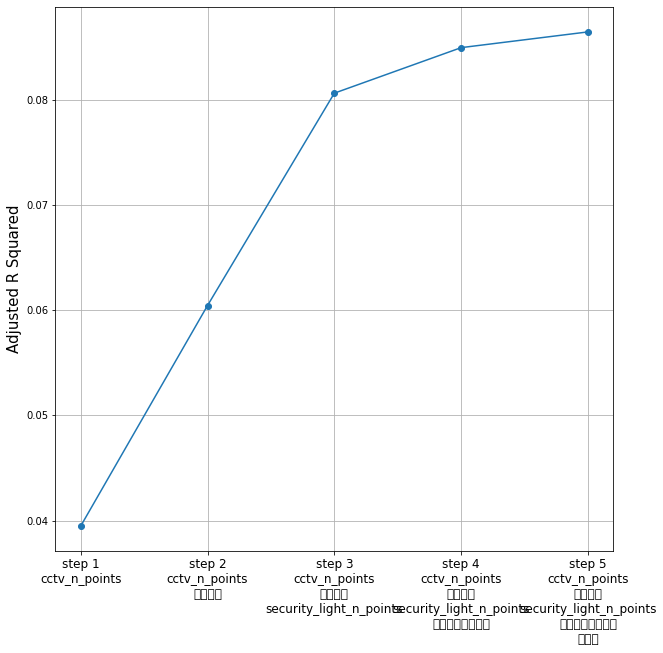

In [20]:
fig = plt.figure(figsize=(10,10))
fig.set_facecolor('white')
#plt.rc('font', family='NanumBarunGothic')
 
font_size = 15
plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12)
plt.plot(steps,adjusted_r_squared, marker='o')
    
plt.ylabel('Adjusted R Squared',fontsize=font_size)
plt.grid(True)
plt.show()

In [21]:
#2021 cctv유의
df_reg = df_all[(df_all['year']==2019)|(df_all['year']==2020)]
col=['cctv_n_points', 'security_light_n_points', 
      '어린이집', '아동안전지킴이집']

X = df_reg[col]
y = df_reg['police_weight']

model  = sm.OLS(y,X)
res =model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          police_weight   R-squared (uncentered):                   0.416
Model:                            OLS   Adj. R-squared (uncentered):              0.416
Method:                 Least Squares   F-statistic:                              838.4
Date:                Fri, 19 Aug 2022   Prob (F-statistic):                        0.00
Time:                        02:05:47   Log-Likelihood:                         -12470.
No. Observations:                4707   AIC:                                  2.495e+04
Df Residuals:                    4703   BIC:                                  2.497e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
cctv_n_points               0.8004      0.039     20.727      0.000       0.725       0.876
security_light_n_points     0.4356      0.014     30.963      0.000       0.408       0.463
어린이집                        2.3722      0.091     26.031      0.000       2.194       2.551
아동안전지킴이집                    2.4095      0.391      6.169      0.000       1.644       3.175
==============================================================================
Omnibus:                      980.435   Durbin-Watson:                   0.480
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2803.234
Skew:                          -1.089   Prob(JB):                         0.00
Kurtosis:                       6.090   Cond. No.                         30.7
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# 최종 격자 말들기

In [22]:
# 2021년도 데이터
data_raw = df_all[df_all['year']==2021]

# 2021년도 데이터에 cctv를 모든 격자에 설치한다고 가정
data_test = df_all[df_all['year']==2021]
data_test['cctv_n_points'] = data_test['cctv_n_points'] +1

In [23]:
col=['cctv_n_points', 'security_light_n_points', '어린이집', '아동안전지킴이집']
ypred_plus = res.predict(data_test[col]) # 2021년도 112신고건수 예측
ypred_raw = res.predict(data_raw[col]) # cctv가 모든 격자에 설치되었을때, 격자별 112신고건수 예측


In [24]:
gid = data_raw['gid']
police_weight=data_raw['police_weight']
test_pred = pd.DataFrame({'gid':gid,'police_weight':police_weight})
test_pred['ypred_plus'] = ypred_plus
test_pred['ypred_raw'] = ypred_raw

In [25]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [26]:
rmse(ypred_raw, data_test['police_weight'])

3.8150463176458476

In [27]:
test_pred['exp'] = test_pred['police_weight'] - test_pred['ypred_plus'] 
test_pred

,gid,police_weight,ypred_plus,ypred_raw,exp
3,마라099990,0.000000,2.107140,1.306701,-2.107140
7,마라099991,2.944439,4.143584,3.343145,-1.199145
15,마라103995,4.727388,4.143584,3.343145,0.583804
19,마라103996,3.737670,1.236006,0.435567,2.501664
23,마라104995,3.178054,1.236006,0.435567,1.942048
...,...,...,...,...,...
10019,마마312038,0.000000,0.800439,0.000000,-0.800439
10023,마마313014,0.000000,0.800439,0.000000,-0.800439
10027,마마320037,0.000000,0.800439,0.000000,-0.800439
10031,마마346005,3.526361,4.508456,3.708017,-0.982096


In [28]:
test_pred[test_pred['exp']>=0]

,gid,police_weight,ypred_plus,ypred_raw,exp
15,마라103995,4.727388,4.143584,3.343145,0.583804
19,마라103996,3.737670,1.236006,0.435567,2.501664
23,마라104995,3.178054,1.236006,0.435567,1.942048
27,마라104996,2.302585,0.800439,0.000000,1.502146
47,마라110984,3.465736,1.236006,0.435567,2.229730
...,...,...,...,...,...
9987,마마301022,3.401197,1.236006,0.435567,2.165192
9991,마마301023,4.007333,1.671573,0.871134,2.335760
9995,마마301024,3.713572,0.800439,0.000000,2.913133
10003,마마303055,3.526361,1.671573,0.871134,1.854788


In [29]:
test_pred[test_pred['exp']<0]

,gid,police_weight,ypred_plus,ypred_raw,exp
3,마라099990,0.000000,2.107140,1.306701,-2.107140
7,마라099991,2.944439,4.143584,3.343145,-1.199145
31,마라105996,0.000000,0.800439,0.000000,-0.800439
35,마라106996,0.000000,0.800439,0.000000,-0.800439
39,마라108997,0.000000,1.671573,0.871134,-1.671573
...,...,...,...,...,...
10019,마마312038,0.000000,0.800439,0.000000,-0.800439
10023,마마313014,0.000000,0.800439,0.000000,-0.800439
10027,마마320037,0.000000,0.800439,0.000000,-0.800439
10031,마마346005,3.526361,4.508456,3.708017,-0.982096


In [30]:
# ypred_raw(112신고 예측:위험지수), exp(112신고 감소 폭:기대효과)
scaler = StandardScaler()
exp_1= test_pred['exp']
exp_2 = exp_1.values.reshape(-1, 1)
test_pred['exp_scale'] = scaler.fit_transform(exp_2)

ypred_raw_1 = test_pred['ypred_raw']
ypred_raw_2 = ypred_raw_1.values.reshape(-1, 1)
test_pred['ypred_raw_scale'] = scaler.fit_transform(ypred_raw_2)
test_pred['sum'] = test_pred['exp_scale'] + test_pred['ypred_raw_scale']
test_pred

,gid,police_weight,ypred_plus,ypred_raw,exp,exp_scale,ypred_raw_scale,sum
3,마라099990,0.000000,2.107140,1.306701,-2.107140,-1.600767,-0.226188,-1.826955
7,마라099991,2.944439,4.143584,3.343145,-1.199145,-1.248130,0.625385,-0.622746
15,마라103995,4.727388,4.143584,3.343145,0.583804,-0.555689,0.625385,0.069696
19,마라103996,3.737670,1.236006,0.435567,2.501664,0.189149,-0.590466,-0.401318
23,마라104995,3.178054,1.236006,0.435567,1.942048,-0.028189,-0.590466,-0.618655
...,...,...,...,...,...,...,...,...
10019,마마312038,0.000000,0.800439,0.000000,-0.800439,-1.093285,-0.772606,-1.865891
10023,마마313014,0.000000,0.800439,0.000000,-0.800439,-1.093285,-0.772606,-1.865891
10027,마마320037,0.000000,0.800439,0.000000,-0.800439,-1.093285,-0.772606,-1.865891
10031,마마346005,3.526361,4.508456,3.708017,-0.982096,-1.163835,0.777962,-0.385873


In [31]:
test_pred['rank'] =  test_pred['sum'].rank(method='max', ascending=False)
test_pred = test_pred.sort_values('rank')
test_pred

,gid,police_weight,ypred_plus,ypred_raw,exp,exp_scale,ypred_raw_scale,sum,rank
4563,마라243939,8.665441,9.158302,8.357864,-0.492862,-0.973832,2.722370,1.748538,1.0
7215,마라278953,8.159089,6.694456,5.894017,1.464633,-0.213602,1.692073,1.478471,2.0
6011,마라258934,7.849324,10.465003,9.664564,-2.615679,-1.798268,3.268788,1.470520,3.0
4559,마라243938,8.314832,4.010359,3.209921,4.304473,0.889304,0.569675,1.458978,4.0
7011,마라276943,8.493105,0.800439,0.000000,7.692667,2.205172,-0.772606,1.432567,5.0
...,...,...,...,...,...,...,...,...,...
423,마라162983,0.000000,0.800439,0.000000,-0.800439,-1.093285,-0.772606,-1.865891,2350.0
9655,마마190070,0.000000,0.800439,0.000000,-0.800439,-1.093285,-0.772606,-1.865891,2350.0
9647,마마190018,0.000000,0.800439,0.000000,-0.800439,-1.093285,-0.772606,-1.865891,2350.0
9791,마마215078,0.000000,0.800439,0.000000,-0.800439,-1.093285,-0.772606,-1.865891,2350.0


In [32]:
pd.merge(test_pred,df_all,on='gid',how='inner')[0:50]

,gid,police_weight_x,ypred_plus,ypred_raw,exp,exp_scale,ypred_raw_scale,sum,rank,cctv_n_points,police_weight_y,security_light_n_points,bell_n_points,cctv_buffer,year,어린이집,유치원,초중고,초등학교,중학교,고등학교,아동안전지킴이집
0,마라243939,8.665441,9.158302,8.357864,-0.492862,-0.973832,2.722370,1.748538,1.0,0.0,6.896694,10.0,0.0,1.0,2018.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,마라243939,8.665441,9.158302,8.357864,-0.492862,-0.973832,2.722370,1.748538,1.0,0.0,7.915713,10.0,0.0,1.0,2019.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,마라243939,8.665441,9.158302,8.357864,-0.492862,-0.973832,2.722370,1.748538,1.0,0.0,8.372167,10.0,0.0,1.0,2020.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,마라243939,8.665441,9.158302,8.357864,-0.492862,-0.973832,2.722370,1.748538,1.0,5.0,8.665441,10.0,0.0,1.0,2021.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,마라278953,8.159089,6.694456,5.894017,1.464633,-0.213602,1.692073,1.478471,2.0,0.0,6.562444,8.0,0.0,1.0,2018.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,마라278953,8.159089,6.694456,5.894017,1.464633,-0.213602,1.692073,1.478471,2.0,0.0,7.562162,8.0,0.0,1.0,2019.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,마라278953,8.159089,6.694456,5.894017,1.464633,-0.213602,1.692073,1.478471,2.0,0.0,7.906547,8.0,0.0,1.0,2020.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,마라278953,8.159089,6.694456,5.894017,1.464633,-0.213602,1.692073,1.478471,2.0,0.0,8.159089,8.0,0.0,1.0,2021.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8,마라258934,7.849324,10.465003,9.664564,-2.615679,-1.798268,3.268788,1.470520,3.0,0.0,6.086775,13.0,0.0,1.0,2018.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,마라258934,7.849324,10.465003,9.664564,-2.615679,-1.798268,3.268788,1.470520,3.0,0.0,7.221836,13.0,0.0,1.0,2019.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
final = test_pred[['rank','gid']]
final = final[(final['rank']>=1)&(final['rank']<=50)].reset_index()
final = final[['rank','gid']]
final.columns = ['우선순위','격자번호(100X100)']
print(final.shape)
final

(50, 2)


,우선순위,격자번호(100X100)
0,1.0,마라243939
1,2.0,마라278953
2,3.0,마라258934
3,4.0,마라243938
4,5.0,마라276943
5,6.0,마라188888
6,7.0,마라184895
7,8.0,마라245971
8,9.0,마라278952
9,10.0,마라257933


In [34]:
final.to_csv('final.csv')